In [45]:
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
import sys
sys.path.append('../src/')
import data_layer

In [ ]:
MIN_OCCURENCES=5

In [17]:
df_wiki = pd.read_csv("../dat/wiki/graph.csv")
df_llm = pd.read_json("../dat/llm/graph.json")
df_textbook = pd.read_json("../dat/textbooks/graph.json").iloc[:,[0,3]]
df_textbook.columns=['concept','dep_articles_textbook']
df_wiki.dep_articles = [[dep[1] for dep in ast.literal_eval(deps)] for deps in (df_wiki.dep_articles)]

In [22]:
_, _, df_count = data_layer.read_index_and_wiki_concepts(include_counts=True)

In [23]:
deps = pd.merge(df_wiki[['concept', 'dep_articles']], df_llm[['concept', 'dep_articles']], on="concept", suffixes=('_wiki', '_llm'))
deps = pd.merge(deps[['concept', 'dep_articles_wiki', 'dep_articles_llm']], df_textbook[['concept', 'dep_articles_textbook']], on="concept")
deps = pd.merge(deps, df_count, on="concept")

In [38]:
def get_number_common_concepts(concept, first, second):
    deps1 = set(first)
    deps2 = set(second)
    if len(deps1.intersection(deps2)):
        #print(f"{concept}: {first} vs {second}")
        pass
    return len(deps1.intersection(deps2))

deps['num_common_tb_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_wiki), axis=1)
deps['num_common_tb_llm'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_llm), axis=1)
deps['num_common_llm_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_llm, r.dep_articles_wiki), axis=1)

In [61]:
filter = deps['count']>=MIN_OCCURENCES

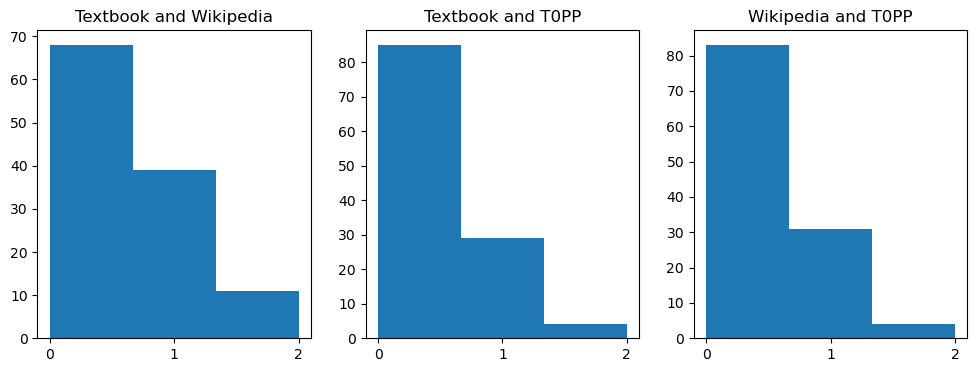

In [62]:
figs, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].set_title("Textbook and Wikipedia")
ax[0].hist(deps.loc[filter,'num_common_tb_wiki'], bins=3)
ax[1].set_title("Textbook and T0PP")
ax[1].hist(deps.loc[filter,'num_common_tb_llm'], bins=3)
ax[2].set_title("Wikipedia and T0PP")
ax[2].hist(deps.loc[filter,'num_common_llm_wiki'], bins=3)
for i in range(3): ax[i].set_xticks(range(3))
plt.show()

### + 2nd level

In [63]:
def get_2leveldeps(dep_articles,colname):
    deps2lev = deps.loc[deps['concept'].isin(dep_articles),colname].to_list()
    if deps2lev:
        if isinstance(deps2lev[0],list):
            deps2_lev_flat=[dep for dep_list in deps2lev for dep in dep_list]
            return deps2_lev_flat + dep_articles
        else:    
            return list(set(deps2lev[0]+dep_articles))
    else:
        return dep_articles


deps['2levdeps_tb'] = deps['dep_articles_textbook'].apply(lambda x: get_2leveldeps(x,'dep_articles_textbook'))
deps['2levdeps_llm'] = deps['dep_articles_llm'].apply(lambda x: get_2leveldeps(x,'dep_articles_llm'))
deps['2levdeps_wiki'] = deps['dep_articles_wiki'].apply(lambda x: get_2leveldeps(x, 'dep_articles_wiki'))

deps['num_common_tb_wiki2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_tb'], r['2levdeps_wiki']), axis=1)
deps['num_common_tb_llm2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_tb'], r['2levdeps_llm']), axis=1)
deps['num_common_llm_wiki2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_llm'], r['2levdeps_wiki']), axis=1)

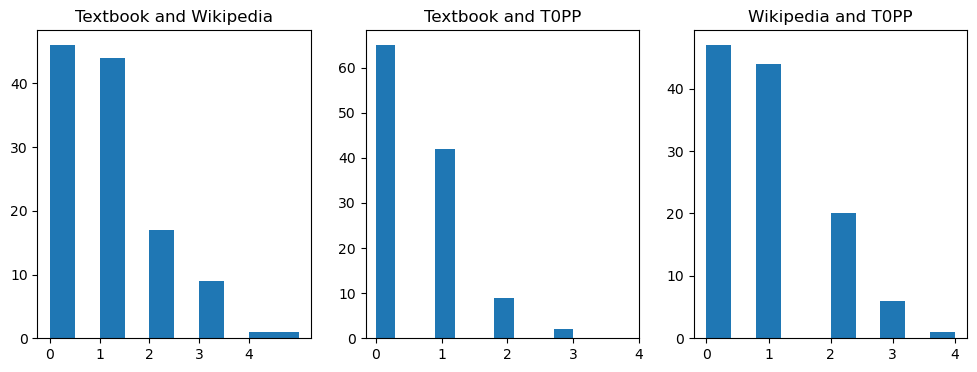

In [64]:
figs, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].set_title("Textbook and Wikipedia")
ax[0].hist(deps.loc[filter,'num_common_tb_wiki2'])
ax[1].set_title("Textbook and T0PP")
ax[1].hist(deps.loc[filter, 'num_common_tb_llm2'])
ax[2].set_title("Wikipedia and T0PP")
ax[2].hist(deps.loc[filter, 'num_common_llm_wiki2'])
for i in range(3): ax[i].set_xticks(range(5))
plt.show()